In [1]:
%matplotlib inline 
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 6

import itertools
import nltk
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

from textblob import TextBlob

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import statsmodels.api as sm
from statsmodels.formula.api import logit, glm, ols

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import metrics

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from inspect import signature

from sklearn.metrics import roc_auc_score

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import graphviz

# Reviews Data Cleaning and Preparation

In [2]:
df = pd.read_csv('NY_reviews.csv')
df['comments']=df['comments'].str.lower()
#nltk.download('stopwords')
#nltk.download('punkt')
stopwords = set(stopwords.words('english'))
df['comments']=df['comments'].apply(str)
df=df[df.comments.map(lambda x: x.isascii())]
df['cleaned'] = df['comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
i=0
data = []
for s in df['cleaned']:
    word = s.split()
    cleaned = ' '.join(i for i in word if i not in stopwords and i not in string.punctuation)
    cleaned = [re.sub(r'[^\w\s]', '', cleaned)]
    data.append(cleaned)
    
   
df['CleanedNew'] = pd.DataFrame(data)
df['CleanedNew'] = df['CleanedNew'].str.replace('\d+', '')
df['CleanedNew'] = df.CleanedNew.replace('<br/>','', regex=True)
df1=df.dropna()

<ipython-input-2-c4a463ad391b>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df['CleanedNew'] = df['CleanedNew'].str.replace('\d+', '')


In [3]:
word_counts=pd.DataFrame(df.CleanedNew.str.split(expand=True).stack().value_counts())

In [4]:
word_counts.reset_index(level=0, inplace=True)
word_counts['words']=word_counts['index']
word_counts.rename(columns={0:'Count'}, inplace=True )
word_counts.loc[word_counts['Count'] >=500]
word_counts=word_counts.drop('index',axis=1)
count_new=word_counts.loc[word_counts['Count'] >=500]

# Sentiment Analysis using TextBlob

In [5]:
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
   return TextBlob(text).sentiment.polarity

In [6]:
df1['Subjectivity'] =df1['CleanedNew'].apply(getSubjectivity)
df1['Polarity'] =df1['CleanedNew'].apply(getPolarity)

<ipython-input-6-6ebec0c13b07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Subjectivity'] =df1['CleanedNew'].apply(getSubjectivity)
<ipython-input-6-6ebec0c13b07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Polarity'] =df1['CleanedNew'].apply(getPolarity)


In [7]:
def getAnalysis(score):
    if score<=0:
        return 'Negative'
    else:
        return 'Positive'

In [8]:
df1['Sentiment'] =df1['Polarity'].apply(getAnalysis)

<ipython-input-8-83d2a0f27f5b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Sentiment'] =df1['Polarity'].apply(getAnalysis)


In [9]:
Pos=df1[df1['Sentiment']=='Positive']
Neg=df1[df1['Sentiment']=='Negative']

In [10]:
from PIL import Image 
mask_pos=np.array(Image.open("Positive.png"))
mask_neg=np.array(Image.open("Negative.png"))

# Positive Wordcloud 

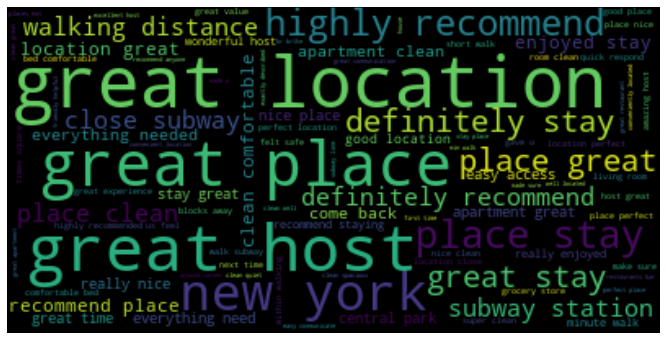

In [11]:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(review for review in Pos.CleanedNew)
wordcloud = WordCloud(stopwords=STOPWORDS).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('Positive.png')
plt.show()

# Negative Wordcloud 

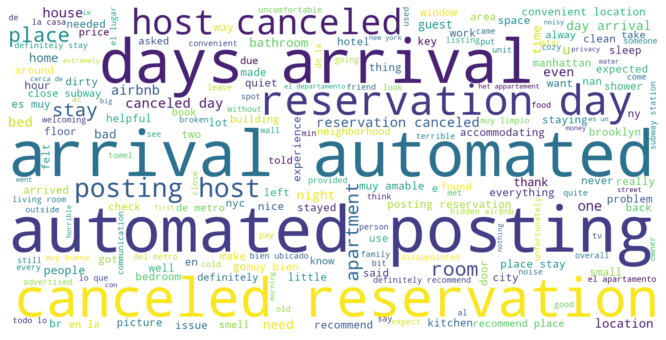

In [12]:
texttn = " ".join(review for review in Neg.CleanedNew)
wordcloud = WordCloud(background_color='white',width=1600, height=800).generate(texttn)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('Negative.png')
plt.show()

Creating a new dataset with the Subjectivity and Polarity scores and adding a flag for negative comments 

In [13]:
df2=df1.drop(['comments','cleaned','date'],axis=1)
reviews_final=pd.DataFrame(df2.groupby("listing_id").mean())
reviews_final=reviews_final.drop(['id','reviewer_id'],axis=1)

In [14]:
df2['Target_Sentiment']=np.where(df2.Sentiment.values=='Negative',1,0)
df2 = df2.drop('Sentiment',axis=1)

# Listings Data Cleaning and Preparation

In [15]:
NY= pd.read_csv('NY_listings.csv')
NY_Copy=NY
NY_Copy['City']='New York'
NY_Copy['neighbourhood']=NY_Copy['neighbourhood'].astype(str)
NY_Copy=NY_Copy[NY_Copy.neighbourhood.map(lambda x: x.isascii())]
drop_params=['last_review','first_review','host_neighbourhood','host_response_time','calendar_updated','bathrooms','listing_url','scrape_id','last_scraped','description','neighborhood_overview','picture_url','host_url','host_about','host_verifications','host_thumbnail_url','host_picture_url','neighbourhood_group_cleansed','calendar_last_scraped','license']
NY_Copy=NY_Copy.drop(drop_params,axis=1)
NY_Copy = NY_Copy[NY_Copy['review_scores_rating'].notna()]
NY_Copy=NY_Copy.dropna()
cols=['name','host_id','host_name','host_since','host_location','host_has_profile_pic','neighbourhood_cleansed','latitude','longitude','amenities','property_type','neighbourhood','City']
NY_Copy=NY_Copy.drop(cols,axis=1)
NY_Copy['superhost'] = np.where(NY_Copy['host_is_superhost']=='t',1, 0)
NY_Copy['identity_verified'] = np.where(NY_Copy['host_identity_verified']=='t',1, 0)
NY_Copy['availability'] = np.where(NY_Copy['has_availability']=='t',1, 0)
NY_Copy['bookable'] = np.where(NY_Copy['instant_bookable']=='t',1, 0)
NY_Copy['type'] = np.where(NY_Copy['room_type']=='Entire home/apt',1,np.where(NY_Copy['room_type']=='Private room',2,np.where(NY_Copy['room_type']=='Hotel room',3,4)))
NY_Copy['bathrooms_text']=np.where(NY_Copy['bathrooms_text']=='Half-bath','0.5 baths',NY_Copy['bathrooms_text'])
NY_Copy['bathrooms_text']=np.where(NY_Copy['bathrooms_text']=='Private half-bath','0.5 baths',NY_Copy['bathrooms_text'])
NY_Copy['bathrooms_text']=np.where(NY_Copy['bathrooms_text']=='Shared half-bath','0.5 baths',NY_Copy['bathrooms_text'])
NY_Copy['bathrooms_text']=NY_Copy['bathrooms_text'].astype(str)
NY_Copy['bathrooms']=NY_Copy.bathrooms_text.str.extract('(\d+)')
NY_Copy['rent']=NY_Copy.price.str.extract('(\d+)')
NY_Copy['host_acceptance_rate']=NY_Copy['host_acceptance_rate'].astype(str)
NY_Copy['host_response_rate']=NY_Copy['host_response_rate'].astype(str)
NY_Copy['acceptance_rate']=NY_Copy.host_acceptance_rate.str.extract('(\d+)')
NY_Copy['response_rate']=NY_Copy.host_response_rate.str.extract('(\d+)')
cols2=['host_is_superhost','host_identity_verified','has_availability','instant_bookable','room_type','bathrooms_text','host_acceptance_rate','host_response_rate']
NY_Copy=NY_Copy.drop(cols2,axis=1)
NY_Copy=NY_Copy.drop('price',axis=1)
NY_Copy=pd.DataFrame(NY_Copy)

C:\Users\Lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
rating_mean=NY_Copy["review_scores_rating"].mean()
reviews_final.reset_index(inplace=True)

In [17]:
final_data=pd.merge(NY_Copy,reviews_final, left_on="id", right_on="listing_id").drop(['listing_id'], axis=1)
final_data['Ratings'] = np.where(final_data['review_scores_rating']<=4.7,1, 0)
final_data=final_data.drop('review_scores_rating',axis=1)

# Logistic Regression

Benchmark Model

In [18]:
y=final_data[['Ratings']]
X=final_data.drop(['Ratings','id'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30)

Accuracy: 0.6798088410991637
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      1120
           1       0.58      0.12      0.20       554

    accuracy                           0.68      1674
   macro avg       0.63      0.54      0.50      1674
weighted avg       0.65      0.68      0.60      1674

0.6676379577101598


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


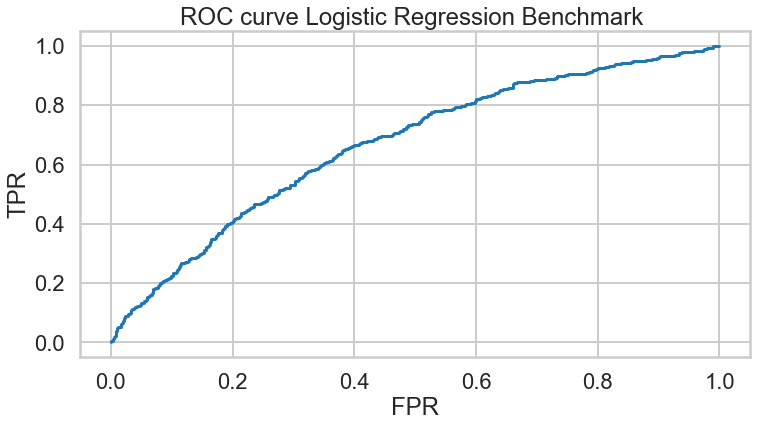

In [19]:
logreg = LogisticRegression()
logreg.fit(X_train,np.ravel(y_train))
y_pred = logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))
predictionslog1=logreg.predict_proba(X_test)

print(roc_auc_score(y_test,predictionslog1[:,1]))

predictionslog2=logreg.predict_proba(X_test)

fpr3, tpr3, _ = roc_curve(y_test,predictionslog2[:,1])

plt.clf()
plt.plot(fpr3,tpr3)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve Logistic Regression Benchmark ')
plt.show()

Feature Selection 

In [20]:
sfs= SFS(LogisticRegression(max_iter=10000),
          k_features=10,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 0)
#sfs.fit(X_train,y_train)
sfs.fit(X_train,np.ravel(y_train))
sfs.k_feature_names_

('minimum_nights',
 'maximum_nights_avg_ntm',
 'availability_30',
 'number_of_reviews',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'rent')

Logistic Regression with the Important Variables

In [21]:
m= logit('Ratings ~ review_scores_checkin+reviews_per_month+review_scores_accuracy+review_scores_cleanliness+review_scores_communication+review_scores_location+review_scores_value+Subjectivity+Polarity',final_data).fit()
print(m.summary())

Optimization terminated successfully.
         Current function value: 0.292887
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                Ratings   No. Observations:                 5578
Model:                          Logit   Df Residuals:                     5568
Method:                           MLE   Df Model:                            9
Date:                Mon, 25 Apr 2022   Pseudo R-squ.:                  0.5375
Time:                        00:19:25   Log-Likelihood:                -1633.7
converged:                       True   LL-Null:                       -3532.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      97.9725      3.001     32.648      0.000   

In [22]:
y_log=final_data[['Ratings']]
X_log=final_data[['review_scores_accuracy','review_scores_value','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','Subjectivity','Polarity','reviews_per_month' ]]
X_trainlog, X_testlog, y_trainlog, y_testlog = train_test_split(X_log,y_log,test_size=0.30)

In [23]:
logreg.fit(X_trainlog,np.ravel(y_trainlog))
y_predlog = logreg.predict(X_testlog)
print('Accuracy of logistic regression classifier with significant variables: {:.2f}'.format(logreg.score(X_testlog,y_testlog)))
print("Accuracy:",metrics.accuracy_score(y_testlog,y_predlog))
print(metrics.classification_report(y_testlog,y_predlog))

Accuracy of logistic regression classifier with significant variables: 0.88
Accuracy: 0.8811230585424134
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1137
           1       0.86      0.75      0.80       537

    accuracy                           0.88      1674
   macro avg       0.87      0.85      0.86      1674
weighted avg       0.88      0.88      0.88      1674



C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9362201487464971


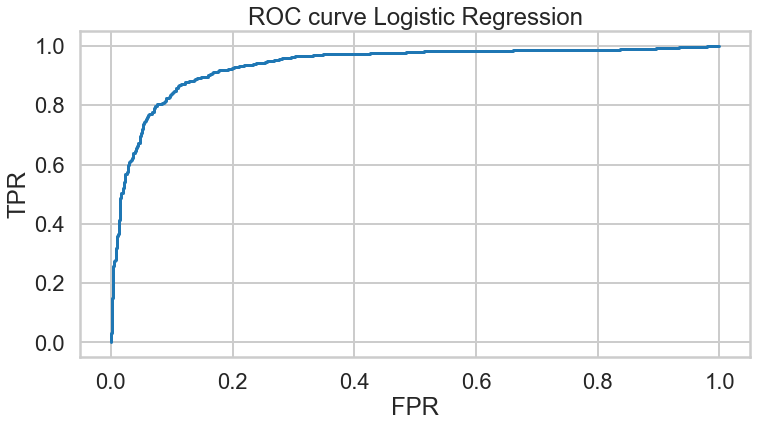

In [24]:
logreg.fit(X_trainlog,np.ravel(y_trainlog))

predictionslog=logreg.predict_proba(X_testlog)

print(roc_auc_score(y_testlog,predictionslog[:,1]))

fpr, tpr, _ = roc_curve(y_testlog,predictionslog[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve Logistic Regression')
plt.show()

# Random Forest

Feature Selection

In [25]:
rf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf.fit(X_train,np.ravel(y_train))

RandomForestClassifier(n_jobs=1)

In [26]:
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
Imp_features=feature_imp[:10]

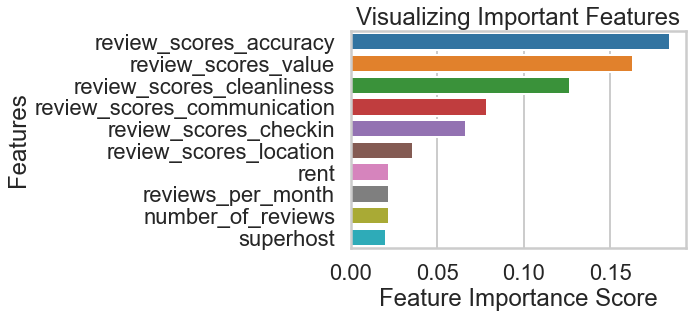

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=Imp_features,y=Imp_features.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

Random Forest Classifier

In [28]:
y_rf=final_data[['Ratings']]
X_rf=final_data[['review_scores_accuracy','review_scores_value','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','rent','Subjectivity','Polarity','reviews_per_month' ]]
X_trainRF, X_testRF, y_trainRF, y_testRF = train_test_split(X_rf,y_rf,test_size=0.30)

In [29]:
rf.fit(X_trainRF,np.ravel(y_trainRF))
y_predRF=rf.predict(X_testRF)
print("Accuracy:",metrics.accuracy_score(y_testRF,y_predRF))
print("Precision:",metrics.precision_score(y_testRF,y_predRF))
print("Recall:",metrics.recall_score(y_testRF,y_predRF))
print(metrics.classification_report(y_testRF,y_predRF))

Accuracy: 0.8841099163679809
Precision: 0.8310940499040307
Recall: 0.8033395176252319
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1135
           1       0.83      0.80      0.82       539

    accuracy                           0.88      1674
   macro avg       0.87      0.86      0.87      1674
weighted avg       0.88      0.88      0.88      1674



Checking variation in accuracy with change in max depth 

[]

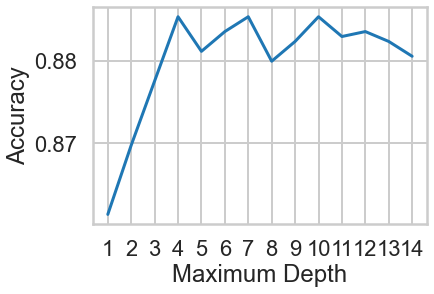

In [80]:
test_errors_RF = [] # Log testing errors for each model

for x in range(1,15):
    rfc=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=x, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    rfc.fit(X_trainRF,np.ravel(y_trainRF))

    test_z1 = rfc.predict(X_testRF)

    test_errors_RF.append(metrics.accuracy_score(y_testRF, test_z1))
x = np.arange(len(range(1,15))) + 1 # Create domain for plot
plt.plot(x, test_errors_RF, label='Testing Error') # Plot testing error over domain
plt.xlabel('Maximum Depth') # Label x-axis
plt.xticks(x)
plt.ylabel('Accuracy') 
plt.plot()

Random Forest with max depth=10

In [35]:
rf1=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10,max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
rf1.fit(X_trainRF,np.ravel(y_trainRF))
y_predRF1=rf1.predict(X_testRF)
print("Accuracy:",metrics.accuracy_score(y_testRF,y_predRF1))
print("Precision:",metrics.precision_score(y_testRF,y_predRF1))
print("Recall:",metrics.recall_score(y_testRF,y_predRF1))
print(metrics.classification_report(y_testRF,y_predRF1))

Accuracy: 0.8847072879330944
Precision: 0.8276515151515151
Recall: 0.8107606679035251
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1135
           1       0.83      0.81      0.82       539

    accuracy                           0.88      1674
   macro avg       0.87      0.87      0.87      1674
weighted avg       0.88      0.88      0.88      1674



0.9515663694392456


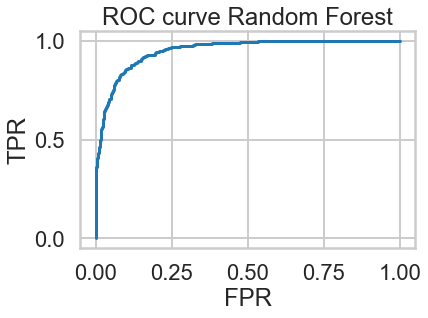

In [37]:
rf1.fit(X_trainRF,np.ravel(y_trainRF))

predictionsrf= rf1.predict_proba(X_testRF)

print(roc_auc_score(y_testRF,predictionsrf[:,1]))

fpr, tpr, _ = roc_curve(y_testRF,predictionsrf[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve Random Forest')
plt.show()

# Decision Tree Classifier 

In [38]:
DC = DecisionTreeClassifier(criterion="entropy", max_depth=4)

In [39]:
DC.fit(X_trainRF,y_trainRF)
y_predDC=DC.predict(X_testRF)
print("Accuracy:",metrics.accuracy_score(y_testRF,y_predDC))
print("Precision:",metrics.precision_score(y_testRF,y_predDC))
print("Recall:",metrics.recall_score(y_testRF,y_predDC))
print(metrics.classification_report(y_testRF,y_predDC))

Accuracy: 0.8709677419354839
Precision: 0.8111753371868978
Recall: 0.7810760667903525
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1135
           1       0.81      0.78      0.80       539

    accuracy                           0.87      1674
   macro avg       0.85      0.85      0.85      1674
weighted avg       0.87      0.87      0.87      1674



In [40]:
DC1 = DecisionTreeClassifier(criterion="entropy", max_depth=7)

In [41]:
DC1.fit(X_trainRF,y_trainRF)
y_predDC1=DC1.predict(X_testRF)
print("Accuracy:",metrics.accuracy_score(y_testRF,y_predDC1))
print("Precision:",metrics.precision_score(y_testRF,y_predDC1))
print("Recall:",metrics.recall_score(y_testRF,y_predDC1))

Accuracy: 0.8602150537634409
Precision: 0.7893738140417458
Recall: 0.7717996289424861


In [42]:
DC2 = DecisionTreeClassifier(criterion="entropy", max_depth=2)

In [43]:
DC2.fit(X_trainRF,y_trainRF)
y_predDC2=DC2.predict(X_testRF)
print("Accuracy:",metrics.accuracy_score(y_testRF,y_predDC2))
print("Precision:",metrics.precision_score(y_testRF,y_predDC2))
print("Recall:",metrics.recall_score(y_testRF,y_predDC2))

Accuracy: 0.8602150537634409
Precision: 0.8622327790973872
Recall: 0.673469387755102


In [44]:
new_features=['review_scores_accuracy','review_scores_value','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','rent','Subjectivity','Polarity']

Checking variation in accuracy with change in max depth 

[]

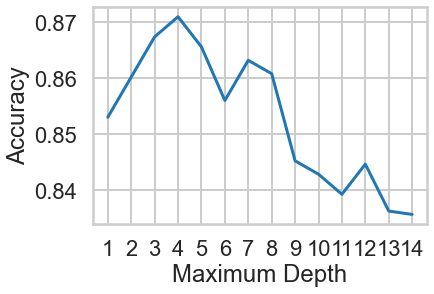

In [45]:
test_errors = [] # Log testing errors for each model

for x in range(1,15):
    dtc = DecisionTreeClassifier(criterion="entropy",max_depth=x) 
    dtc.fit(X_trainRF,y_trainRF)
#    train_z = dtc.predict(X_trainRF)
    test_z = dtc.predict(X_testRF)
#    train_errors.append(accuracy_score(train_x, train_z))
    test_errors.append(metrics.accuracy_score(y_testRF,test_z))
x = np.arange(len(range(1,15))) + 1 # Create domain for plot
#plt.plot(x, train_errors, label='Training Error') # Plot training error over domain
plt.plot(x, test_errors, label='Testing Error') # Plot testing error over domain
plt.xlabel('Maximum Depth') # Label x-axis
plt.xticks(x)
plt.ylabel('Accuracy') # Label y-axis
#plt.legend() # Show plot labels as legend
plt.plot() # Show graph

0.9304683988132699


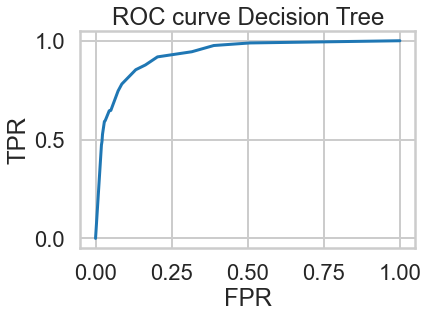

In [46]:
DC.fit(X_trainRF,y_trainRF)
#y_predDC=DC.predict(X_testRF)
#DC.fit(X_train, y_train)
predictions = DC.predict_proba(X_testRF)

print(roc_auc_score(y_testRF,predictions[:,1]))

fpr1,tpr1, _ = roc_curve(y_testRF,predictions[:,1])

plt.clf()
plt.plot(fpr1,tpr1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve Decision Tree')
plt.show()